**PINN implementation for 100x100 grid using deepxde**

In [ ]:
pip install tensorflow==2.10.0
pip install matplotlib==3.7.4
pip install scipy==1.10.1
pip install pandas==2.0.3
pip install deepxde==1.10.1
pip install numpy==1.24.3
pip install scikit-learn==1.3.2

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
import os
import random
import deepxde as dde
# Set default floating-point type
tf.keras.backend.set_floatx('float32')

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



In [2]:
# Set seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Configure TensorFlow for deterministic behavior
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Control threading for reproducibility
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Ensure GPU determinism
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Define He initializer
initializer = tf.keras.initializers.HeNormal(seed=seed_value)

*Same as with the LSTM models we construct arrays*

In [3]:
sorted_concatenated_csv = "C:/Users/Giannis/Documents/uva-thesis/neural-agent-models/data/simulation data/100x100.csv"
data = pd.read_csv(sorted_concatenated_csv)
#data.drop(columns=['zCOM'], inplace=True)
print(data.head())
data['time'] = (data['mcsteps'] / 10000).astype(int)
data = data[['time'] + [col for col in data.columns if col != 'time']]
data.drop(columns=['mcsteps'], inplace=True)
print(data)
cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']
smallest_values = data[cytokine_columns].min()
largest_values = data[cytokine_columns].max()

print("Smallest values for each cytokine:")
print(smallest_values)
print("\nLargest values for each cytokine:")
print(largest_values)
#def replace_negative_with_zero(data):
 #   num_negative_values = (data < 0).sum().sum()
  #  data[data < 0] = 0

   # return num_negative_values

#cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

#for col in cytokine_columns:
 #   num_negatives = replace_negative_with_zero(data[col])
  #  print(f"Number of negative values replaced with 0 in '{col}': {num_negatives}")

# define cytokines
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# Remove brackets and convert to float
for col in cytokines:
    data[col] = data[col].str.strip('[]').astype(float)

# get unique time values
unique_time = data['time'].unique()

arrays = {}

# iterate over unique time values
for time in unique_time:
    # filter data for current value of time
    data_time = data[data['time'] == time]
    
    # initialize 50x50x6 array for current value of time
    array = np.zeros((100, 100, len(cytokines)))
    
    # get X and Y coordinates
    x = data_time['xCOM'].astype(int)
    y = data_time['yCOM'].astype(int)
    
    # get cytokine concentrations
    concentrations = data_time[['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']].values
    
    # assign cytokine concentrations to corresponding position in array
    array[x, y, :] = concentrations
    
    # store array for current value of time
    arrays[time] = array

   mcsteps  xCOM  yCOM              il8   il1   il6  il10   tnf   tgf
0        0    78    62   [8.155469e-08]  [0.]  [0.]  [0.]  [0.]  [0.]
1        0    29    17   [3.716848e-09]  [0.]  [0.]  [0.]  [0.]  [0.]
2        0    64    24  [3.4276149e-09]  [0.]  [0.]  [0.]  [0.]  [0.]
3        0    77    16  [3.7302027e-13]  [0.]  [0.]  [0.]  [0.]  [0.]
4        0    29     7  [3.9552712e-16]  [0.]  [0.]  [0.]  [0.]  [0.]
       time  xCOM  yCOM              il8              il1              il6  \
0         0    78    62   [8.155469e-08]             [0.]             [0.]   
1         0    29    17   [3.716848e-09]             [0.]             [0.]   
2         0    64    24  [3.4276149e-09]             [0.]             [0.]   
3         0    77    16  [3.7302027e-13]             [0.]             [0.]   
4         0    29     7  [3.9552712e-16]             [0.]             [0.]   
...     ...   ...   ...              ...              ...              ...   
33842   100    97    49  [1.413103

*creating input/output pairs for the PINN*

In [4]:
sequence_length = 2
input_sequences = []
output_values = []

# convert dictionary values to a list of arrays
arrays_list = [arrays[key] for key in sorted(arrays.keys())]

# convert 'arrays' list to numpy array
arrays_np = np.array(arrays_list)

for i in range(len(arrays_np) - sequence_length):
    input_seq = arrays_np[i:i+sequence_length]  # input sequence of arrays
    output_val = arrays_np[i+sequence_length]   # array at next time step
    
    input_sequences.append(input_seq)
    output_values.append(output_val)

# convert lists to numpy arrays
input_sequences = np.array(input_sequences)
output_values = np.array(output_values)

print(input_sequences.shape)
print(output_values.shape)

(99, 2, 100, 100, 6)
(99, 100, 100, 6)


*In the next few cells we extract cellposition from .vtk files which is essential to compute the pde residual in the PINN*

In [5]:
def read_vtk_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    dimensions = None
    cell_type_data_start = None
    for i, line in enumerate(lines):
        if line.startswith("DIMENSIONS"):
            dimensions = list(map(int, line.split()[1:]))
        elif line.startswith("CellType"):
            cell_type_data_start = i + 1
            break
    
    if dimensions is None or cell_type_data_start is None:
        raise ValueError("Invalid VTK file format")
    
    grid_data = []
    data_lines = lines[cell_type_data_start:]
    for line in data_lines:
        if line.strip() and not line.startswith("FIELD"):
            try:
                grid_data.extend(map(int, line.split()))
                if len(grid_data) >= dimensions[0] * dimensions[1]:
                    break
            except ValueError:
                continue  # Skip lines that can't be converted to int
    
    expected_size = dimensions[0] * dimensions[1]
    if len(grid_data) != expected_size:
        raise ValueError(f"Data size {len(grid_data)} does not match expected size {expected_size}")

    grid_data = np.array(grid_data[:expected_size]).reshape((dimensions[0], dimensions[1], 1))
    return grid_data

def process_vtk_files(directory):
    vtk_arrays = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".vtk"):
            filepath = os.path.join(directory, filename)
            grid_data = read_vtk_file(filepath)
            vtk_arrays.append(grid_data)
    return vtk_arrays

directory = "C:/Users/Giannis/Documents/neural-agent-models-main/data/LatticeData/LatticeData(100x100)"
vtk_arrays = process_vtk_files(directory)

# Check the 3D array for a specific coordinate and timestep
timestep = 0  # Timestep index
x, y = 10, 10  # Coordinates to check
cell_type = vtk_arrays[timestep][x, y, 0]
print(f"The cell type at ({x}, {y}) at timestep {timestep} is {cell_type}")

# The vtk_arrays will contain all the 3D arrays for each timestep

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/Giannis/Documents/neural-agent-models-main/data/LatticeData/LatticeData(100x100)'

In [6]:
def check_cell_presence(vtk_arrays, start_idx, end_idx):
    cellpresente = []
    cellpresentndn = []
    cellpresentna = []
    cellpresentm1 = []
    cellpresentm2 = []

    for i in range(start_idx, end_idx + 1):
        array = vtk_arrays[i].reshape(100, 100)
        cellpresente.append(1 if np.any(array == 1) else 0)
        cellpresentndn.append(1 if np.any(array == 2) else 0)
        cellpresentna.append(1 if np.any(array == 5) else 0)
        cellpresentm1.append(1 if np.any(array == 8) else 0)
        cellpresentm2.append(1 if np.any(array == 9) else 0)
    return cellpresente, cellpresentndn, cellpresentna, cellpresentm1, cellpresentm2

# Adjust the range to 0-100
cellpresente, cellpresentndn, cellpresentna, cellpresentm1, cellpresentm2 = check_cell_presence(vtk_arrays, 0, 100)

# Output the results
for t in range(0, 101):
    idx = t  # Index directly corresponds to the timestep
    print(f"Timestep {t}:")
    print(f"  cellpresente: {cellpresente[idx]}")
    print(f"  cellpresentndn: {cellpresentndn[idx]}")
    print(f"  cellpresentna: {cellpresentna[idx]}")
    print(f"  cellpresentm1: {cellpresentm1[idx]}")
    print(f"  cellpresentm2: {cellpresentm2[idx]}")

output_dir = 'C:/Users/Ioannis/Documents/neural-agent-models/data/PINN/Results'
os.makedirs(output_dir, exist_ok=True)

results = np.column_stack((range(0, 101), cellpresente, cellpresentndn, cellpresentna, cellpresentm1, cellpresentm2))
np.savetxt(os.path.join(output_dir, 'cell_presence_results.csv'), results, delimiter=',', header='Timestep,cellpresente,cellpresentndn,cellpresentna,cellpresentm1,cellpresentm2', comments='', fmt='%d')

Timestep 0:
  cellpresente: 1
  cellpresentndn: 1
  cellpresentna: 1
  cellpresentm1: 0
  cellpresentm2: 0
Timestep 1:
  cellpresente: 1
  cellpresentndn: 1
  cellpresentna: 1
  cellpresentm1: 1
  cellpresentm2: 1
Timestep 2:
  cellpresente: 1
  cellpresentndn: 1
  cellpresentna: 1
  cellpresentm1: 1
  cellpresentm2: 1
Timestep 3:
  cellpresente: 1
  cellpresentndn: 1
  cellpresentna: 1
  cellpresentm1: 1
  cellpresentm2: 1
Timestep 4:
  cellpresente: 1
  cellpresentndn: 1
  cellpresentna: 1
  cellpresentm1: 1
  cellpresentm2: 1
Timestep 5:
  cellpresente: 1
  cellpresentndn: 1
  cellpresentna: 1
  cellpresentm1: 1
  cellpresentm2: 1
Timestep 6:
  cellpresente: 1
  cellpresentndn: 1
  cellpresentna: 1
  cellpresentm1: 1
  cellpresentm2: 1
Timestep 7:
  cellpresente: 1
  cellpresentndn: 1
  cellpresentna: 1
  cellpresentm1: 1
  cellpresentm2: 1
Timestep 8:
  cellpresente: 1
  cellpresentndn: 1
  cellpresentna: 1
  cellpresentm1: 1
  cellpresentm2: 1
Timestep 9:
  cellpresente: 1
  cellp

PermissionError: [WinError 5] Access is denied: 'C:/Users/Ioannis'

*Parameters for our PINN to solve the PDE*

In [5]:
# Simulation parameters
nx = 100
true_size = 5
s_mcs = 60.0
h_mcs = 1 / 60.0
lineconv = true_size / nx
areaconv = true_size**2 / nx**2
volumeconv = (true_size**2 * 1) / (nx**2 * 1)

# Parameters for each cytokine
Dil8 = 2.09e-6 * s_mcs / areaconv
muil8 = 0.2 * h_mcs
keil8 = 234e-5 * volumeconv * h_mcs
kndnil8 = 1.46e-5 * volumeconv * h_mcs
thetanail8 = 3.024e-5 * volumeconv * h_mcs

Dil1 = 3e-7 * s_mcs / areaconv
muil1 = 0.6 * h_mcs
knail1 = 225e-5 * volumeconv * h_mcs

Dil6 = 8.49e-8 * s_mcs / areaconv
muil6 = 0.5 * h_mcs
km1il6 = 250e-5 * volumeconv * h_mcs

Dil10 = 1.45e-8 * s_mcs / areaconv
muil10 = 0.5 * h_mcs
km2il10 = 45e-5 * volumeconv * h_mcs

Dtnf = 4.07e-9 * s_mcs / areaconv
mutnf = 0.5 * 0.225 * h_mcs
knatnf = 250e-5 * volumeconv * h_mcs
km1tnf = 70e-5 * volumeconv * h_mcs

Dtgf = 2.6e-7 * s_mcs / areaconv
mutgf = 0.5 * (1 / 25) * h_mcs
km2tgf = 280e-5 * volumeconv * h_mcs

cellpresente = np.array([
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
])

cellpresentndn = np.array([
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1
])

cellpresentna = np.array([
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
])

cellpresentm1 = np.array([
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1
])

cellpresentm2 = np.array([
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
])




# Optionally, print the arrays to verify
print("cellpresente:", cellpresente.shape)
print("cellpresentndn:", cellpresentndn.shape)
print("cellpresentna:", cellpresentna.shape)
print("cellpresentm1:", cellpresentm1.shape)
print("cellpresentm2:", cellpresentm2.shape)

# Convert the NumPy arrays to TensorFlow constants
cellpresente_tf = tf.constant(cellpresente, dtype=tf.float32)
cellpresentndn_tf = tf.constant(cellpresentndn, dtype=tf.float32)
cellpresentna_tf = tf.constant(cellpresentna, dtype=tf.float32)
cellpresentm1_tf = tf.constant(cellpresentm1, dtype=tf.float32)
cellpresentm2_tf = tf.constant(cellpresentm2, dtype=tf.float32)

# Define the parameters as TensorFlow constants
keil8_tf = tf.constant(keil8, dtype=tf.float32)
knail1_tf = tf.constant(knail1, dtype=tf.float32)
km1il6_tf = tf.constant(km1il6, dtype=tf.float32)
km2il10_tf = tf.constant(km2il10, dtype=tf.float32)
knatnf_tf = tf.constant(knatnf, dtype=tf.float32)
km2tgf_tf = tf.constant(km2tgf, dtype=tf.float32)
kndnil8_tf = tf.constant(kndnil8, dtype=tf.float32)
km1tnf_tf = tf.constant(km1tnf, dtype=tf.float32)
thetanail8_tf = tf.constant(thetanail8, dtype=tf.float32)

# diffusion degradation secretion endocytosis
D = np.array([Dil8, Dil1, Dil6, Dil10, Dtnf, Dtgf])
k = np.array([muil8, muil1, muil6, muil10, mutnf, mutgf])

# Stack the parameters for secretion and endocytosis
s1 = tf.stack([
    keil8_tf * cellpresente_tf,
    knail1_tf * cellpresentna_tf,
    km1il6_tf * cellpresentm1_tf,
    km2il10_tf * cellpresentm1_tf,
    knatnf_tf * cellpresentna_tf,
    km2tgf_tf * cellpresentm2_tf
], axis=0)

s2 = tf.stack([
    kndnil8_tf * cellpresentndn_tf,
    tf.zeros_like(cellpresentndn_tf, dtype=tf.float32),
    tf.zeros_like(cellpresentndn_tf, dtype=tf.float32),
    tf.zeros_like(cellpresentndn_tf, dtype=tf.float32),
    km1tnf_tf * cellpresentm1_tf,
    tf.zeros_like(cellpresentndn_tf, dtype=tf.float32)
], axis=0)

e = tf.stack([
    thetanail8_tf * cellpresentna_tf,
    tf.zeros_like(cellpresentndn_tf, dtype=tf.float32),
    tf.zeros_like(cellpresentndn_tf, dtype=tf.float32),
    tf.zeros_like(cellpresentndn_tf, dtype=tf.float32),
    tf.zeros_like(cellpresentndn_tf, dtype=tf.float32),
    tf.zeros_like(cellpresentndn_tf, dtype=tf.float32)
], axis=0)

print("s1:", s1)
print("s2:", s2)
print("e:", e)

cellpresente: (99,)
cellpresentndn: (99,)
cellpresentna: (99,)
cellpresentm1: (99,)
cellpresentm2: (99,)
s1: Tensor("stack:0", shape=(6, 99), dtype=float32)
s2: Tensor("stack_1:0", shape=(6, 99), dtype=float32)
e: Tensor("stack_2:0", shape=(6, 99), dtype=float32)


*PINN implementation using deepxde, this cell contains everything including the NN architecture, loss function, metrics, etc*

In [6]:
print("D:", D)
print("k:", k)
print("s1:", s1)
print("s2:", s2)
print("e:", e)

# Define the PDE
def pde(x, y):
    u = [y[:, i:i+1] for i in range(6)]
    laplacian_u = [dde.grad.hessian(u[i], x, i=1, j=1) + dde.grad.hessian(u[i], x, i=2, j=2) for i in range(6)]
    laplacian_u = tf.concat(laplacian_u, axis=1)
    degradation = k * y

    # Extract the time component from x
    time_idx = tf.cast(tf.floor(x[:, 2]), tf.int32)

    # Gather the appropriate values from s1, s2, and e based on time_idx
    secretion_1 = tf.gather(tf.transpose(s1), time_idx)
    secretion_2 = tf.gather(tf.transpose(s2), time_idx)
    endocytosis = tf.gather(tf.transpose(e), time_idx) * y

    return laplacian_u * D - degradation + secretion_1 + secretion_2 - endocytosis

# Define the geometry and time domain
geom = dde.geometry.Rectangle([0, 0], [100, 100])
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the initial condition
def initial_condition(x):
    return np.zeros((x.shape[0], 6))

# Define the Neumann boundary condition
def neumann_boundary(x, on_boundary):
    return on_boundary

def neumann_bc(x, y, nx, ny):
    grad = [dde.grad.jacobian(y, x, i=0, j=j) for j in range(3)]
    return sum([g * n for g, n in zip(grad, [nx, ny])])

# Initial and boundary conditions
ic = dde.IC(geomtime, initial_condition, lambda _, on_initial: on_initial)
bc = dde.NeumannBC(geomtime, neumann_bc, neumann_boundary)

# Reshape input_sequences
input_sequences_reshaped = input_sequences.reshape(input_sequences.shape[0], -1)

# Flatten the output values
output_values_reshaped = output_values.reshape(output_values.shape[0], -1)

# Define train, validation, and test sizes
train_size = int(0.72 * input_sequences_reshaped.shape[0])
val_size = int(0.1 * input_sequences_reshaped.shape[0])
test_size = input_sequences_reshaped.shape[0] - train_size - val_size

# Split data
X_train = input_sequences_reshaped[:train_size]
X_val = input_sequences_reshaped[train_size:train_size + val_size]
X_test = input_sequences_reshaped[train_size + val_size:]
y_train = output_values_reshaped[:train_size]
y_val = output_values_reshaped[train_size:train_size + val_size]
y_test = output_values_reshaped[train_size + val_size:]

#train_size = int(0.7 * input_sequences_reshaped.shape[0])
#test_size = int(0.19 * input_sequences_reshaped.shape[0])
#val_size = input_sequences_reshaped.shape[0] - train_size - test_size

#X_train = input_sequences_reshaped[:train_size]
#X_test = input_sequences_reshaped[train_size:train_size + test_size]
#X_val = input_sequences_reshaped[train_size + test_size:]

#y_train = output_values_reshaped[:train_size]
#y_test = output_values_reshaped[train_size:train_size + test_size]
#y_val = output_values_reshaped[train_size + test_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

class SaveTrainingDataCallback(dde.callbacks.Callback):
    def __init__(self, filename, interval=1000):
        self.filename = filename
        self.interval = interval
        self.history = []
        self.model = None

    def set_model(self, model):
        self.model = model

    def on_train_begin(self):
        print("Starting training...")

    def get_learning_rate(self):
        # Safeguard to get the learning rate from the optimizer
        try:
            return self.model.opt.learning_rate.numpy()
        except AttributeError:
            try:
                return self.model.opt.lr.numpy()
            except AttributeError:
                return None

    def on_epoch_end(self):
        # Save training data at specified intervals
        if self.model.train_state.epoch % self.interval == 0:
            # Collect data to save
            current_data = {
                'epoch': self.model.train_state.epoch,
                'train_loss': self.model.train_state.loss_train,
                'test_loss': self.model.train_state.loss_test,
                'metrics': self.model.train_state.metrics_test,
                'lr': self.get_learning_rate()
            }
            self.history.append(current_data)
            # Save to file
            np.save(self.filename, self.history)
            print(f"Saved training data at epoch {self.model.train_state.epoch}")

    def on_train_end(self):
        # Save final training data
        np.save(self.filename, self.history)
        print("Training finished and data saved.")


# Custom data set
data = dde.data.DataSet(
    X_train,
    y_train,
    X_val,
    y_val,
)

print("Custom data set defined")

# Construct the neural network with LAAF-10 relu activation
activation = "LAAF-10 relu"
net = dde.maps.FNN([input_sequences_reshaped.shape[1]] + [50] * 3 + [output_values_reshaped.shape[1]], activation, "Glorot uniform")

# Ensure the output layer uses ReLU to prevent negative predictions
net.apply_output_transform(lambda x, y: tf.nn.relu(y))

# Define the model
model = dde.Model(data, net)

# Define the PDE residual function
def pde_residual(x, y):
    return pde(x, y)

save_training_data_callback = SaveTrainingDataCallback(filename='C:/Users/Giannis/Documents/uva-thesis/neural-agent-models/data/training_data/PINN(100x100)(82)_train_data.npy', interval=1000)

# Compile the model with combined losses: data loss (MSE) and PDE residual loss
model.compile("adam", lr=1e-3, metrics=["mean squared error"])

# Adding the physics-informed loss component directly into the training process
losshistory, train_state = model.train(iterations=10000, display_every=1000, callbacks=[save_training_data_callback])

#metrics
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-10):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), epsilon, None)))

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_logarithmic_error(y_true, y_pred):
    return np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2)

def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def accuracy(y_true, y_pred):
    abs_diff = np.abs(y_true - y_pred)
    threshold = 0.2 * np.abs(y_true)
    accurate_predictions = abs_diff <= threshold
    accuracy = np.mean(accurate_predictions)
    return accuracy

y_pred = model.predict(X_test)

# Reshape the predictions and true values
y_pred_reshaped = y_pred.reshape(y_test.shape[0], 100, 100, 6)
y_test_reshaped = y_test.reshape(y_test.shape[0], 100, 100, 6)

# Evaluate the model using various metrics
mape = mean_absolute_percentage_error(y_test_reshaped, y_pred_reshaped)
mse = mean_squared_error(y_test_reshaped, y_pred_reshaped)
mae = mean_absolute_error(y_test_reshaped, y_pred_reshaped)
msle = mean_squared_logarithmic_error(y_test_reshaped, y_pred_reshaped)
r2 = r_squared(y_test_reshaped, y_pred_reshaped)
acc = accuracy(y_test_reshaped, y_pred_reshaped)

print("Mean Absolute Percentage Error (MAPE) on the test set:", mape)
print("Mean Squared Error (MSE) on the test set:", mse)
print("Mean Absolute Error (MAE) on the test set:", mae)
print("Mean Squared Logarithmic Error (MSLE) on the test set:", msle)
print("R-squared (R²) on the test set:", r2)
print("Accuracy on the test set:", acc)

print("y_pred:", y_pred.shape)
print("y_pred_flat:", y_pred_reshaped.shape)

D: [5.0160e-02 7.2000e-03 2.0376e-03 3.4800e-04 9.7680e-05 6.2400e-03]
k: [0.00333333 0.01       0.00833333 0.00833333 0.001875   0.00033333]
s1: Tensor("stack:0", shape=(6, 99), dtype=float32)
s2: Tensor("stack_1:0", shape=(6, 99), dtype=float32)
e: Tensor("stack_2:0", shape=(6, 99), dtype=float32)
X_train shape: (71, 120000), y_train shape: (71, 60000)
X_val shape: (9, 120000), y_val shape: (9, 60000)
X_test shape: (19, 120000), y_test shape: (19, 60000)
Custom data set defined
Compiling model...
Building feed-forward neural network...
'build' took 0.135845 s



c:\Users\Giannis\Documents\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.343209 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.00e-15]    [3.41e-15]    [3.41e-15]    
Starting training...
1000      [1.84e-16]    [3.89e-16]    [3.89e-16]    
Saved training data at epoch 1000
2000      [1.84e-16]    [3.89e-16]    [3.89e-16]    
Saved training data at epoch 2000
3000      [1.84e-16]    [3.89e-16]    [3.89e-16]    
Saved training data at epoch 3000
4000      [1.84e-16]    [3.89e-16]    [3.89e-16]    
Saved training data at epoch 4000
5000      [1.84e-16]    [3.89e-16]    [3.89e-16]    
Saved training data at epoch 5000
6000      [1.84e-16]    [3.89e-16]    [3.89e-16]    
Saved training data at epoch 6000
7000      [1.84e-16]    [3.89e-16]    [3.89e-16]    
Saved training data at epoch 7000
8000      [1.84e-16]    [3.89e-16]    [3.89e-16]    
Saved training data at epoch 8000
9000      [1.84e-16]    [3.89e-16]    [3.89e-16]    
Saved training data at epoch 9000
10000     [1.84e-16]    [3.89e-16]    [3.89e

*Export the data from the predictions*

In [7]:
import numpy as np
import pandas as pd

# Assuming y_pred and y_test are already available in the environment
y_pred_reshaped = y_pred.reshape(y_test.shape[0], 100, 100, 6)
y_test_reshaped = y_test.reshape(y_test.shape[0], 100, 100, 6)

print("Prediction completed")
print("y_pred reshaped:", y_pred_reshaped.shape)
print("y_test reshaped:", y_test_reshaped.shape)

y_pred = y_pred_reshaped
y_test = y_test_reshaped

y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

# Create arrays for x and y coordinates
X = np.arange(y_test_shape[1])
Y = np.arange(y_test_shape[2])

# Initialize a list to hold all data for the DataFrame
all_data = []

# Loop through each timestep and collect the data
for timestep in range(y_pred_shape[0]):
    for i in X:
        for j in Y:
            if not np.all(y_pred[timestep, i, j] == 0):  # Only include non-zero entries
                data_point = {'timestep': timestep, 'x': i, 'y': j}
                data_point.update({f'feature_{k+1}': y_pred[timestep, i, j, k] for k in range(y_pred_shape[-1])})
                all_data.append(data_point)

# Create the DataFrame with the correct columns
df_all_timesteps = pd.DataFrame(all_data, columns=['timestep', 'x', 'y', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6'])

# Save the DataFrame to a CSV file
csv_path = 'C:/Users/Giannis/Documents/PINN(100x100)(82-100hrs).csv'
df_all_timesteps.to_csv(csv_path, index=False)

print(f"Data saved to {csv_path}")

Prediction completed
y_pred reshaped: (19, 100, 100, 6)
y_test reshaped: (19, 100, 100, 6)
Data saved to C:/Users/Giannis/Documents/PINN(100x100)(82-100hrs).csv


*Compute the means and std, then plot timeseries for the means of actual vs pred to see general behavior*

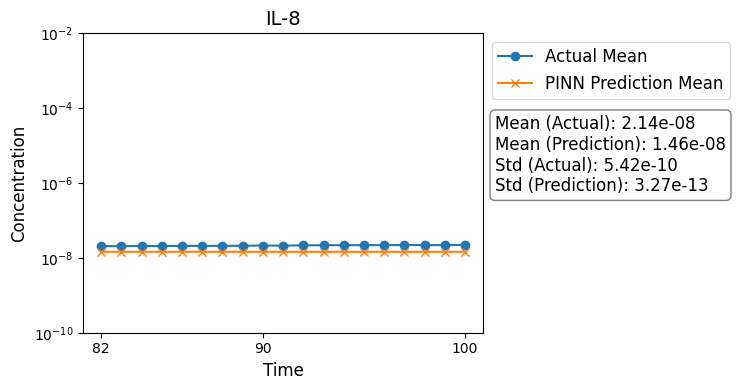

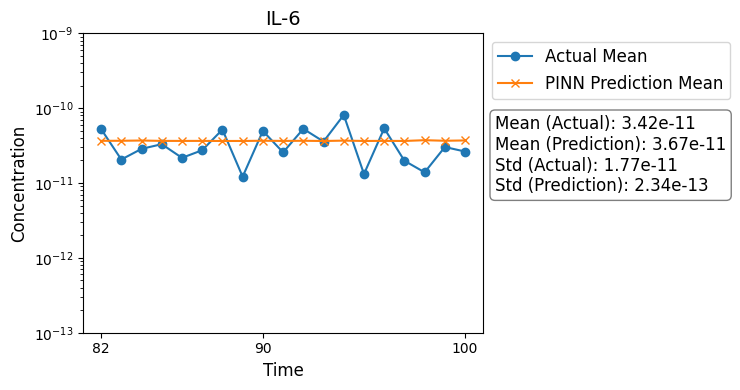

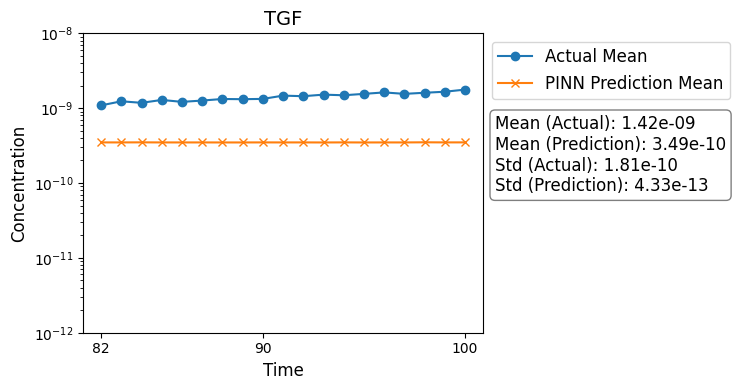

In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Combine y_test and y_pred for easier range calculation
combined_data = np.concatenate([y_test, y_pred])

output_dir = 'plots-PINN'
os.makedirs(output_dir, exist_ok=True)

# Mask zeros and small values, set lower limit for log scale
masked_data = np.ma.masked_equal(combined_data, 0)
lower_limit = 1e-12
upper_limit = 1e-7

# Calculate min and max values for each cytokine, ignoring zeros and clipping
min_values = np.ma.min(masked_data, axis=(0, 1, 2))
max_values = np.ma.max(masked_data, axis=(0, 1, 2))

# Convert masked arrays to regular arrays with NaN where masked
min_values = min_values.filled(np.nan)
max_values = max_values.filled(np.nan)

# Average over the spatial dimensions (X, Y coordinates)
y_test_avg = np.mean(y_test, axis=(1, 2))
y_pred_avg = np.mean(y_pred, axis=(1, 2))

# Calculate mean and std for each cytokine across all time steps
y_test_mean = np.mean(y_test_avg, axis=0)
y_pred_mean = np.mean(y_pred_avg, axis=0)
y_test_std = np.std(y_test_avg, axis=0)
y_pred_std = np.std(y_pred_avg, axis=0)

# Time steps (assuming they are from t=82 to t=100)
time_steps = np.arange(82, 101)
selected_time_steps = [82, 90, 100]

# Labels and corresponding indices to plot
labels_to_plot = ['IL-8', 'IL-6', 'TGF']
indices_to_plot = [0, 2, 5]  # indices for 'IL-8', 'IL-6', 'TGF' in the original labels list
custom_limits = [(1e-10, 1e-2), (1e-13, 1e-9), (1e-12, 1e-8)]

# Plotting each selected feature separately
for i, label, (lower, upper) in zip(indices_to_plot, labels_to_plot, custom_limits):
    plt.figure(figsize=(10, 4))
    plt.plot(time_steps, y_test_avg[:, i], label='Actual Mean', marker='o')
    plt.plot(time_steps, y_pred_avg[:, i], label='PINN Prediction Mean', marker='x')

    plt.ylabel('Concentration', fontsize=12)
    plt.yscale('log')
    plt.ylim(lower, upper)
    
    plt.xticks(selected_time_steps)
    
    # Display means and stds numerically outside the plot
    textstr = '\n'.join((
        f'Mean (Actual): {y_test_mean[i]:.2e}',
        f'Mean (Prediction): {y_pred_mean[i]:.2e}',
        f'Std (Actual): {y_test_std[i]:.2e}',
        f'Std (Prediction): {y_pred_std[i]:.2e}',
    ))
    plt.gcf().text(0.5, 0.7, textstr, fontsize=12,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.xlabel('Time', fontsize=12)
    plt.title(label, fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    
    # Save the plot to the specified folder
    plot_filename = f'{label}_concentrations_time_series.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path, bbox_inches='tight')
    plt.show()